# Calculate POP2 heat budget using xgcm

In this notebook, we are going to use xgcm with metrics to demonstrate budget closure. This notebook was contributed by [Anna-Lena Deppenmeier](https://github.com/ALDepp).


This is an image of the POP output structure on the horizontal B-grid courtesy of [Yassir Eddebbar](https://github.com/Eddebbar).

<img src="POP_Grid.png" alt="Drawing" style="width: 800px;"/>

## Import packages and define functions

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm

import pop_tools


def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()


def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[152, :].values - value))

## Load Dataset

In [2]:
fdir = '/glade/scratch/whokim/archive/g210.G_JRA.v14.gx1v7.01_TB/ocn/hist/'
ds = xr.open_dataset(fdir + 'g210.G_JRA.v14.gx1v7.01_TB.pop.h.0270-01.nc')
# ds = ds.isel(time=0)
# ds

In [6]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 8]
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds.TLAT)

inds_lon = range(95, 185, 5)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds.TLONG)

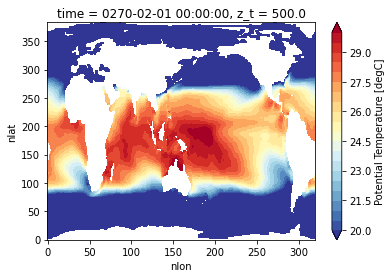

In [5]:
# just making sure everything works
# ds.TEMP.isel(z_t=0).mean(dim="time").plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
ds.TEMP.isel(z_t=0).plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
# plt.scatter(lola_inds["i_140_w"], lola_inds["j_0n"], marker="*");

## Set up vertical thickness and volume for scaling

In [7]:
ds["DZT"] = xr.DataArray(ds.dz.values[:,None,None]*np.ones((len(ds.dz),len(ds.nlat),len(ds.nlon)))
                , dims=['z_t','nlat','nlon'], coords={'z_t':ds.z_t,'nlat':ds.nlat,'nlon':ds.nlon})
ds["DZU"] = xr.DataArray(ds.dz.values[:,None,None]*np.ones((len(ds.dz),len(ds.nlat),len(ds.nlon)))
                , dims=['z_t','nlat','nlon'], coords={'z_t':ds.z_t,'nlat':ds.nlat,'nlon':ds.nlon})

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
KMT = ds.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

100%|██████████| 384/384 [00:00<00:00, 894.63it/s]


## Set up dataset to gather budget terms

In [8]:
budget = xr.Dataset()

### Set grid and data set for xgcm with metrics

In [9]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)

for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

In [9]:
dsxgcm

<xarray.Dataset>
Dimensions:                 (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat_t: 384, nlat_u: 384, nlon_t: 320, nlon_u: 320, time: 1, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/17)
    transport_components    (transport_comp) |S384 b'Total' ... b'Submeso Adv...
    transport_regions       (transport_reg) |S384 b'Global Ocean - Marginal S...
  * time                    (time) object 0270-02-01 00:00:00
  * z_t                     (z_t) float64 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float64 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float64 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
    ...                      ...
    TLONG                   (nlat_t, nlon_t) float64 320.6 321.7 ... 319.4 319.8
    TLAT                    (nlat_t, nlon_t) float64 -79.22 -79.22 ... 72.19
  * nlon_u                  (nlon_u) int64 1 2 3 4 5 6 ... 316 317 318 319 320
  * nlat_u                  (nlat_u) int64 1 2 3 4 5 6 ... 380 381 382 383 384
  * nlon_t                  (nlon_t) float64 0.5 1.5 2.5 ... 317.5 318.5 319.5
  * nlat_t                  (nlat_t) float64 0.5 1.5 2.5 ... 381.5 382.5 383.5
Dimensions without coordinates: d2, moc_comp, transport_comp, transport_reg
Data variables: (12/193)
    time_bound              (time, d2) object 0270-01-01 00:00:00 0270-02-01 ...
    moc_components          (moc_comp) |S384 b'Eulerian Mean' ... b'Submeso'
    dz                      (z_t) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    dzw                     (z_w_top) float64 500.0 1e+03 ... 2.499e+04 2.5e+04
    KMT                     (nlat_t, nlon_t) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    KMU                     (nlat_u, nlon_u) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                      ...
    MOC                     (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
    N_HEAT                  (time, transport_reg, transport_comp, lat_aux_grid) float32 ...
    N_SALT                  (time, transport_reg, transport_comp, lat_aux_grid) float32 ...
    DZT                     (z_t, nlat_t, nlon_t) float64 1e+03 ... 2.5e+04
    DZU                     (z_t, nlat_u, nlon_u) float64 1e+03 ... 2.5e+04
    VOL                     (z_t, nlat_t, nlon_t) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    title:             g210.G_JRA.v14.gx1v7.01_TB
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-03-29 at 14:33:12.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### 0) Tendency

In [10]:
budget['TEND_TEMP'] = dsxgcm.TEND_TEMP

### i) Total heat advection

In [11]:
budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)
budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

In [14]:
dsxgcm.WISOP

<xarray.DataArray 'WISOP' (time: 1, z_w_top: 60, nlat_t: 384, nlon_t: 320)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [-1.37864103e-03,  1.65055716e-04, -7.08715461e-05, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) object 0270-02-01 00:00:00
  * z_w_top  (z_w_top) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
    TLONG    (nlat_t, nlon_t) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT     (nlat_t, nlon_t) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 316.5 317.5 318.5 319.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5
Attributes:
    long_name:     Vertical Bolus Velocity (diagnostic)
    units:         cm/s
    grid_loc:      3112
    cell_methods:  time: mean

### ii) Total heat divergence due to parameterizations

In [18]:
tmp=(dsxgcm.UISOP + dsxgcm.USUBM)*(dsxgcm.dz*dsxgcm.DYT).values/dsxgcm.VOL.values \
    *gridxgcm.interp(dsxgcm.TEMP, 'X')
budget["UET_PARAM"] = -(gridxgcm.diff(tmp * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)

tmp=(dsxgcm.VISOP + dsxgcm.VSUBM)*(dsxgcm.dz*dsxgcm.DXT).values/dsxgcm.VOL.values \
    *gridxgcm.interp(dsxgcm.TEMP, 'Y')
budget["VNT_PARAM"] = -(gridxgcm.diff(tmp * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)

tmp=(dsxgcm.WISOP + dsxgcm.WSUBM)*dsxgcm.DXT*dsxgcm.DYT/dsxgcm.VOL.values \
    *gridxgcm.interp(dsxgcm.TEMP, 'Z')
budget["WTT_PARAM"] = (gridxgcm.diff(tmp.fillna(0)*(dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values
                               , axis="Z")/dsxgcm.VOL)

budget["TOT_PARAM"] = budget.UET_PARAM + budget.VNT_PARAM + budget.WTT_PARAM 

### iii) Heat flux due to vertical mixing:
#### includes surface flux at the 0th layer

In [19]:
budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsxgcm.SHF - dsxgcm.SHF_QSW) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][:,0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

### iv) Heat flux due to horizontal diffusion

In [20]:
budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL
budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"]

### v) Solar Penetration

In [21]:
budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

### plot to make sure it closes at (0N, 140W)

In [22]:
# subset = budget.isel(nlon_t=lola_inds["i_140_w"], nlat_t=lola_inds["j_0n"], time=0)
subset = budget.isel(nlon_t=lola_inds["i_140_w"], nlat_t=lola_inds["j_0n"])

CPU times: user 61.1 ms, sys: 16.4 ms, total: 77.5 ms
Wall time: 519 ms


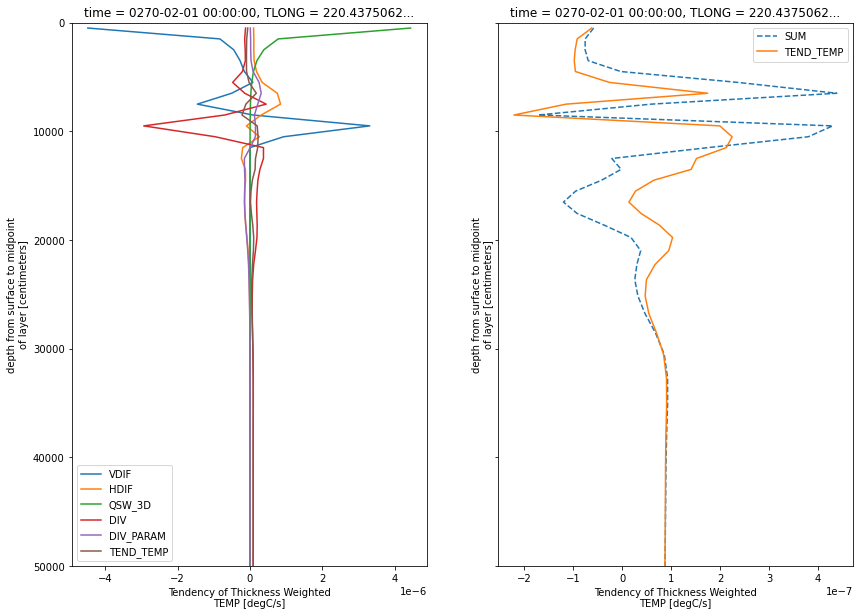

In [23]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# plot individual components
subset.VDIF.plot(y="z_t", ylim=(500e2, 0), label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(500e2, 0), label="HDIF", ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(500e2, 0), label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(500e2, 0), label="DIV", ax=ax[0])
subset.TOT_PARAM.plot(y="z_t", ylim=(500e2, 0), label="DIV_PARAM", ax=ax[0])

# plot sum
# (subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV + subset.TOT_PARAM).plot(
#     y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[0])

# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), label="TEND_TEMP", ax=ax[0])

ax[0].legend()

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV + subset.TOT_PARAM).plot(
    y="z_t", ylim=(500e2, 0), label="SUM", ls="--", ax=ax[1])

# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), label="TEND_TEMP", ax=ax[1])

ax[1].legend();

In [16]:
# You may need to install watermark (conda install -c conda-forge watermark)
import xgcm  # just to display the version

%load_ext watermark
%watermark -d -iv -m -g
print("Above are the versions of the packages this works with.")

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: c1b73199f169ce40d3a7ded125ec0fbbac90b285

matplotlib: 3.3.4
xarray    : 0.17.0
xgcm      : 0.5.1
numpy     : 1.20.1
pop_tools : 2020.12.15.post10+dirty

Above are the versions of the packages this works with.
